Flutungsbeginn war der 12.4.2019. Wir versuchen mit Daten der Sentinel-1- und -2-Satelliten nachzuvollziehen, wie hoch der Wasserstand zum jeweiligen Zeitpunkt war.

In [2]:
from sentinelsat import SentinelAPI, read_geojson, geojson_to_wkt
from datetime import date
import datetime

In [3]:
# --------------------------------------------------------------------------#
# adjust these lines to search for pictures of the fire you want to look at #
# you should not need to changed anything below this cell                   #
# --------------------------------------------------------------------------#

fire_start_date = date(2020, 5, 28)
fire_end_date = date(2020, 6, 1)
fire_location = 'POINT (13.16832 52.25156)' # note that this is in the order longitude, latitude (or x, y)

In [4]:
# Set up the ~/.netrc using the provided ~/.netrc.example in order for this to work
api = SentinelAPI(None, None)

# the "footprint" is what we can use to preselect a certain area;
# the lake is at (51.7874, 14.4226)
# footprint = 'POLYGON((14.359428613281251 51.806620319822734,14.466545312500001 51.806620319822734,14.466545312500001 51.757343872357566,14.359428613281251 51.757343872357566,14.359428613281251 51.806620319822734))'

In [5]:
two_weeks = datetime.timedelta(days=14)
products = api.query(fire_location,
                     platformname='Sentinel-2',
                     processinglevel='Level-2A',
                     date=(fire_start_date - two_weeks, fire_end_date + two_weeks),
                     cloudcoverpercentage=(0,30))

In [8]:
print('Found {} results'.format(len(products)))

Found 9 results


In [9]:
products

OrderedDict([('eb6b190c-7c19-4784-bc37-7a78d0cd8ca3',
              {'title': 'S2B_MSIL2A_20200602T100559_N0214_R022_T32UQC_20200602T135324',
               'link': "https://scihub.copernicus.eu/apihub/odata/v1/Products('eb6b190c-7c19-4784-bc37-7a78d0cd8ca3')/$value",
               'link_alternative': "https://scihub.copernicus.eu/apihub/odata/v1/Products('eb6b190c-7c19-4784-bc37-7a78d0cd8ca3')/",
               'link_icon': "https://scihub.copernicus.eu/apihub/odata/v1/Products('eb6b190c-7c19-4784-bc37-7a78d0cd8ca3')/Products('Quicklook')/$value",
               'summary': 'Date: 2020-06-02T10:05:59.024Z, Instrument: MSI, Mode: , Satellite: Sentinel-2, Size: 967.17 MB',
               'beginposition': datetime.datetime(2020, 6, 2, 10, 5, 59, 24000),
               'endposition': datetime.datetime(2020, 6, 2, 10, 5, 59, 24000),
               'ingestiondate': datetime.datetime(2020, 6, 2, 18, 59, 28, 210000),
               'orbitnumber': 16922,
               'relativeorbitnumber': 2

In [10]:
from collections import Counter

In [11]:
# to reduce download size, only download products for one tile
tiles = Counter([p['filename'].split('_')[5] for _, p in products.items()])
most_common_tile, amount = tiles.most_common(1)[0]
most_common_tile, amount

('T32UQC', 3)

In [15]:
# we create the directory structure we need for the following notebooks
! mkdir -p input/raster

In [16]:
api.download_all({k: v for k, v in products.items() if most_common_tile in v['filename']}, 'input/raster')

Downloading:   0%|          | 2.10M/1.01G [00:00<00:53, 18.8MB/s]
Downloading:   1%|          | 6.29M/1.01G [00:00<00:46, 21.7MB/s]
Downloading:   1%|          | 10.5M/1.01G [00:00<00:41, 24.0MB/s]
Downloading:   1%|▏         | 13.6M/1.01G [00:00<00:38, 25.7MB/s]
Downloading:   2%|▏         | 18.9M/1.01G [00:00<00:33, 30.0MB/s]
Downloading:   2%|▏         | 25.2M/1.01G [00:00<00:28, 35.1MB/s]
Downloading:   3%|▎         | 30.4M/1.01G [00:00<00:26, 37.5MB/s]
Downloading:   3%|▎         | 34.6M/1.01G [00:00<00:27, 36.2MB/s]
Downloading:   3%|▎         | 30.4M/1.02G [00:00<00:25, 38.3MB/s]
Downloading:   4%|▍         | 38.8M/1.01G [00:01<00:28, 34.2MB/s]
Downloading:   4%|▍         | 44.0M/1.01G [00:01<00:25, 37.8MB/s]
Downloading:   5%|▍         | 49.3M/1.01G [00:01<00:23, 40.4MB/s]
Downloading:   6%|▌         | 59.8M/1.01G [00:01<00:21, 44.0MB/s]
Downloading:   6%|▌         | 57.7M/1.02G [00:01<00:21, 44.3MB/s]
Downloading:   6%|▋         | 65.0M/1.01G [00:01<00:21, 43.2MB/s]
Downloadin

({'eb6b190c-7c19-4784-bc37-7a78d0cd8ca3': {'id': 'eb6b190c-7c19-4784-bc37-7a78d0cd8ca3',
   'title': 'S2B_MSIL2A_20200602T100559_N0214_R022_T32UQC_20200602T135324',
   'size': 1014204628,
   'md5': '0B5DAD7BE68ED370FAFB7E22B68FA5A1',
   'date': datetime.datetime(2020, 6, 2, 10, 5, 59, 24000),
   'footprint': 'POLYGON((11.978601830497047 51.32467880575696,11.987408449329669 51.34611323200043,12.047655196300749 51.49192253343463,12.108267095324493 51.6377307348429,12.169312975129742 51.78351193213143,12.230601402802682 51.929272266674246,12.292143016447412 52.074978862471525,12.353763303487082 52.2206525469624,12.387354358116424 52.29966031613883,13.539979680877822 52.26313739791785,13.442095184333063 51.27892518278613,11.978601830497047 51.32467880575696))',
   'url': "https://scihub.copernicus.eu/apihub/odata/v1/Products('eb6b190c-7c19-4784-bc37-7a78d0cd8ca3')/$value",
   'Online': True,
   'Creation Date': datetime.datetime(2020, 6, 2, 19, 2, 5, 206000),
   'Ingestion Date': datetime.

## Previewing Downloaded Files

In [17]:
from glob import glob
downloaded = glob('input/raster/*.zip')

In [18]:
downloaded

['input/raster/S2A_MSIL2A_20200528T101031_N0214_R022_T32UQC_20200528T120203.zip',
 'input/raster/S2B_MSIL2A_20200602T100559_N0214_R022_T32UQC_20200602T135324.zip',
 'input/raster/S2A_MSIL2A_20200521T102031_N0214_R065_T32UQC_20200521T115134.zip']

In [21]:
from pathlib import Path

import rasterio as r
from rasterio import plot

import matplotlib.pyplot as plt
%matplotlib inline

In [22]:
Path(downloaded[0]).name

'S2A_MSIL2A_20200528T101031_N0214_R022_T32UQC_20200528T120203.zip'

In [23]:
import zipfile

def band_paths(p, bands, resolution=None):
    '''
    Given a zip file at `p`, returns the paths inside p to the raster files containing
    information for the given bands. Because some bands are available in more than one
    resolution, this can be filtered by prodiding a third parameter (e.g. resolution='10m').
    
    The returned paths are formatted in the zip scheme as per Apache Commons VFS and can
    thus be directly opened by rasterio.
    '''
    with zipfile.ZipFile(p) as f:
        files = f.namelist()
        rasters = [f for f in files if f.endswith('.jp2')]
        rasters = ['zip+file://' + p + '!/' + r for r in rasters for b in bands if b in r and (not resolution or resolution in r)]
        return rasters

In [24]:
def rgb_paths(zip_file, resolution='10m'):
    return band_paths(zip_file, ['B02', 'B03', 'B04'], resolution)

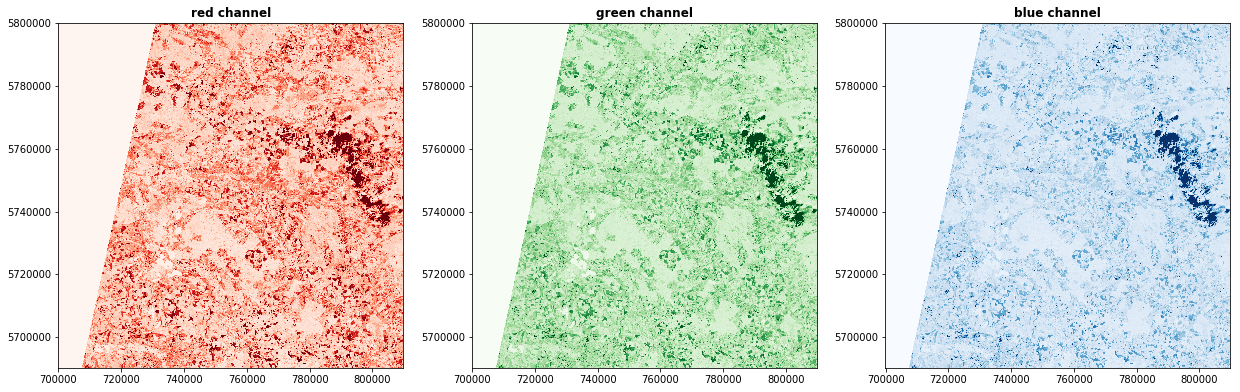

In [26]:
# preview the first downloaded image
with r.open(band_paths(downloaded[1], ['TCI'], '20m')[0]) as true_color:
    fig, (axr, axg, axb) = plt.subplots(1,3, figsize=(21,7))
    plot.show((true_color, 1), ax=axr, cmap='Reds', title='red channel')
    plot.show((true_color, 2), ax=axg, cmap='Greens', title='green channel')
    plot.show((true_color, 3), ax=axb, cmap='Blues', title='blue channel')
    plt.show()